#1. Khởi tạo và Thiết lập Môi trường

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import re
import random
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Kết nối Google Drive
drive.mount('/content/drive')

# Tải tài nguyên NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Đọc dữ liệu
file_path = '/content/drive/MyDrive/labeled_data.csv'
df = pd.read_csv(file_path)

# Ánh xạ nhãn chuẩn
df["labels"] = df["class"].map({0: "Hate", 1: "Offensive", 2: "neither"})

print("Kích thước dữ liệu gốc:", df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Kích thước dữ liệu gốc: (24783, 8)


#2.EDA TRỰC QUAN

/tmp/ipython-input-3099795226.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis')


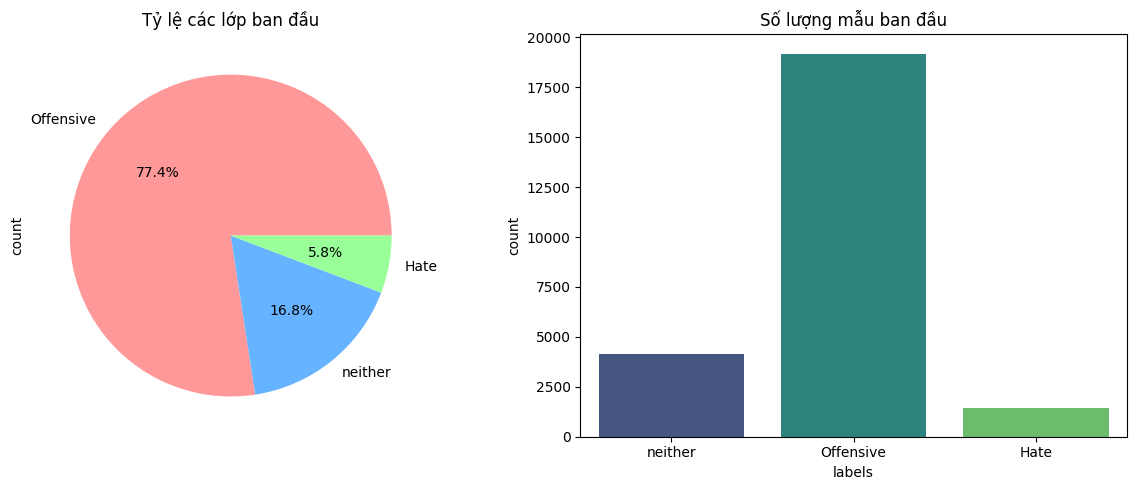

Số lượng cụ thể:
 labels
Offensive    19190
neither       4163
Hate          1430
Name: count, dtype: int64


In [2]:
plt.figure(figsize=(12, 5))

# Biểu đồ tròn
plt.subplot(1, 2, 1)
df['labels'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Tỷ lệ các lớp ban đầu")

# Biểu đồ cột
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='labels', palette='viridis')
plt.title("Số lượng mẫu ban đầu")

plt.tight_layout()
plt.show()

print("Số lượng cụ thể:\n", df['labels'].value_counts())

#3. Chia Tập Dữ liệu

In [3]:
# Chia tập dữ liệu 80% Train, 20% Test
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    df[['tweet']], df['labels'], test_size=0.2, random_state=42, stratify=df['labels']
)

# Tạo DataFrame cho tập Train để thực hiện Augmentation
train_df_orig = pd.concat([X_train_raw, y_train_raw], axis=1)

#4. XỬ LÝ MẤT CÂN BẰNG & TĂNG CƯỜNG DỮ LIỆU

In [4]:
# --- Hàm hỗ trợ Augmentation ---
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace('_', ' ').replace('-', ' ').lower()
            if synonym != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: break
    return new_words

def augment_sentence(sentence):
    words = str(sentence).split()
    if len(words) < 3: return sentence
    n = max(1, int(len(words) * 0.15))
    return ' '.join(synonym_replacement(words, n))

# --- Quy trình cân bằng ---
hate_train = train_df_orig[train_df_orig['labels'] == 'Hate']
offensive_train = train_df_orig[train_df_orig['labels'] == 'Offensive']
neither_train = train_df_orig[train_df_orig['labels'] == 'neither']

# 1. Tăng cường lớp Hate (Tạo thêm 2 biến thể mới cho mỗi câu gốc)
hate_aug1 = hate_train.copy(); hate_aug1['tweet'] = hate_aug1['tweet'].apply(augment_sentence)
hate_aug2 = hate_train.copy(); hate_aug2['tweet'] = hate_aug2['tweet'].apply(augment_sentence)

# 2. Giảm mẫu lớp Offensive xuống mức tương đương các lớp khác
offensive_down = offensive_train.sample(n=4000, random_state=42)

# 3. Gộp lại tập Train mới (Giữ nguyên neither như yêu cầu)
balanced_train_df = pd.concat([
    hate_train, hate_aug1, hate_aug2,
    offensive_down,
    neither_train
], axis=0).reset_index(drop=True)

#5. EDA TRỰC QUAN

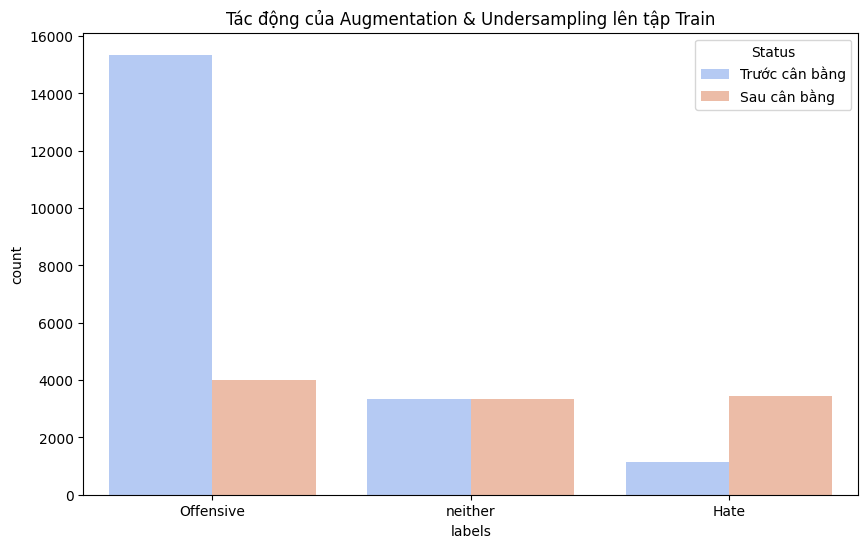

Số lượng tập Train sau xử lý:
 labels
Offensive    4000
Hate         3432
neither      3330
Name: count, dtype: int64


In [6]:
plt.figure(figsize=(10, 6))
# Chuẩn bị dữ liệu vẽ
b_counts = train_df_orig['labels'].value_counts().reset_index(); b_counts['Status'] = 'Trước cân bằng'
a_counts = balanced_train_df['labels'].value_counts().reset_index(); a_counts['Status'] = 'Sau cân bằng'
plot_df = pd.concat([b_counts, a_counts])

sns.barplot(data=plot_df, x='labels', y='count', hue='Status', palette='coolwarm')
plt.title("Tác động của Augmentation & Undersampling lên tập Train")
plt.show()

print("Số lượng tập Train sau xử lý:\n", balanced_train_df['labels'].value_counts())

#6. TIỀN XỬ LÝ VÀ TRÍCH XUẤT ĐẶC TRƯNG

In [7]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

# Áp dụng cho Train (sau cân bằng) và Test (gốc)
balanced_train_df['clean_tweet'] = balanced_train_df['tweet'].apply(preprocess_text)
X_test_clean = X_test_raw['tweet'].apply(preprocess_text)

# Vector hóa TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = tfidf.fit_transform(balanced_train_df['clean_tweet'])
X_test_vec = tfidf.transform(X_test_clean)

#7. Huấn luyện và Đánh giá


BÁO CÁO KẾT QUẢ PHÂN LOẠI (TRÊN TẬP TEST GỐC):
              precision    recall  f1-score   support

        Hate       0.31      0.63      0.42       286
   Offensive       0.97      0.84      0.90      3838
     neither       0.76      0.94      0.84       833

    accuracy                           0.85      4957
   macro avg       0.68      0.80      0.72      4957
weighted avg       0.90      0.85      0.86      4957



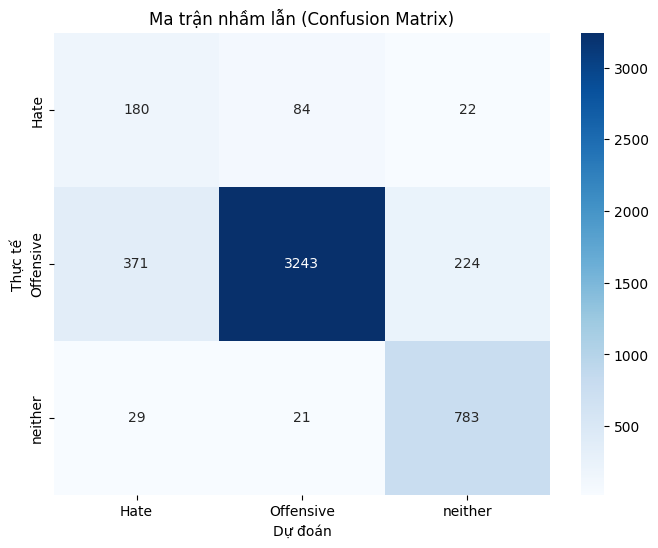

In [8]:
# Huấn luyện mô hình
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, balanced_train_df['labels'])

# Dự đoán
y_pred = clf.predict(X_test_vec)

# Hiển thị kết quả
print("\nBÁO CÁO KẾT QUẢ PHÂN LOẠI (TRÊN TẬP TEST GỐC):")
print(classification_report(y_test_raw, y_pred, target_names=["Hate", "Offensive", "neither"]))

# Ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_raw, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Hate", "Offensive", "neither"],
            yticklabels=["Hate", "Offensive", "neither"])
plt.title("Ma trận nhầm lẫn (Confusion Matrix)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

In [9]:
sample = "i hate you you stupid ugly cunt od a motherfucking whore"
sample = preprocess_text(sample)

In [10]:
sample

'hate stupid ugli cunt od motherfuck whore'

In [11]:
sample_vec = tfidf.transform([sample])

In [12]:
clf.predict(sample_vec)

array(['Hate'], dtype=object)

#8. THỬ NGHIỆM VỚI MÔ HÌNH SVM

--- Đang huấn luyện mô hình SVM ---

BÁO CÁO KẾT QUẢ SVM (TRÊN TẬP TEST GỐC):
              precision    recall  f1-score   support

        Hate       0.28      0.58      0.38       286
   Offensive       0.96      0.84      0.89      3838
     neither       0.74      0.91      0.81       833

    accuracy                           0.83      4957
   macro avg       0.66      0.77      0.70      4957
weighted avg       0.88      0.83      0.85      4957



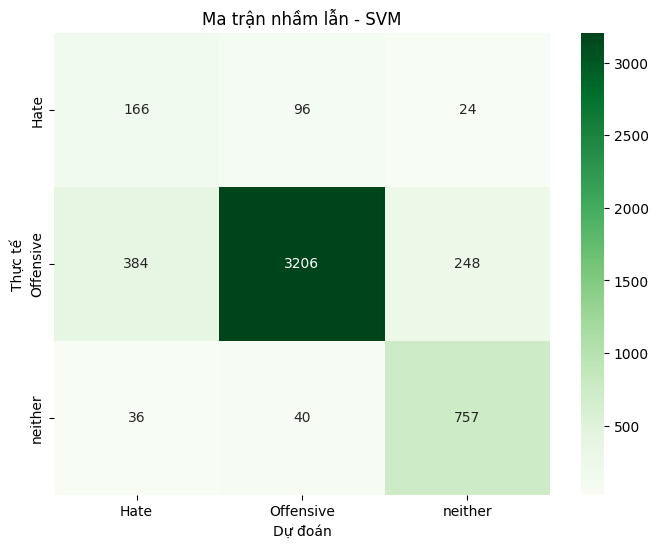

In [13]:
from sklearn.svm import LinearSVC

# 1. Sử dụng tập dữ liệu đã được Vector hóa từ Mục 6
# Lưu ý: Chúng ta dùng X_train_vec và X_test_vec đã có để đảm bảo tính công bằng khi so sánh
# y_train = balanced_train_df['labels']
# y_test = y_test_raw

# 2. Khởi tạo và Huấn luyện SVM
print("--- Đang huấn luyện mô hình SVM ---")
svm_model = LinearSVC(C=1.0, max_iter=2000, random_state=42)
svm_model.fit(X_train_vec, balanced_train_df['labels'])

# 3. Dự đoán và Đánh giá
y_pred_svm = svm_model.predict(X_test_vec)

print("\nBÁO CÁO KẾT QUẢ SVM (TRÊN TẬP TEST GỐC):")
print(classification_report(y_test_raw, y_pred_svm, target_names=["Hate", "Offensive", "neither"]))

# 4. Trực quan hóa Ma trận nhầm lẫn cho SVM
plt.figure(figsize=(8, 6))
cm_svm = confusion_matrix(y_test_raw, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', # Đổi màu sang Green để phân biệt với Logistic
            xticklabels=["Hate", "Offensive", "neither"],
            yticklabels=["Hate", "Offensive", "neither"])
plt.title("Ma trận nhầm lẫn - SVM")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

In [ ]:
# testing on sample text
def predict_sample(text):
    clean_text = preprocess_text(text)
    vec = vectorizer.transform([clean_text])
    pred = svm_model.predict(vec)[0]
    return pred

# Example:
print(predict_sample("So this is what the billionaires do with the money they steal from the hardworking people…"))


Hate


#10.HUẤN LUYỆN MÔ HÌNH RANDOM FOREST

In [14]:
from sklearn.ensemble import RandomForestClassifier

# 1. Khởi tạo mô hình
# n_estimators=100: Sử dụng 100 cây quyết định để bỏ phiếu
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Huấn luyện (Sử dụng dữ liệu đã Vector hóa và Augmentation từ Mục 6)
print("--- Đang huấn luyện mô hình Random Forest ---")
rf_model.fit(X_train_vec, balanced_train_df['labels'])

# 3. Dự đoán và Đánh giá
y_pred_rf = rf_model.predict(X_test_vec)

print("\nBÁO CÁO KẾT QUẢ RANDOM FOREST:")
print(classification_report(y_test_raw, y_pred_rf, target_names=["Hate", "Offensive", "neither"]))

--- Đang huấn luyện mô hình Random Forest ---

BÁO CÁO KẾT QUẢ RANDOM FOREST:
              precision    recall  f1-score   support

        Hate       0.33      0.60      0.43       286
   Offensive       0.97      0.86      0.91      3838
     neither       0.77      0.94      0.85       833

    accuracy                           0.86      4957
   macro avg       0.69      0.80      0.73      4957
weighted avg       0.90      0.86      0.87      4957



BẢNG SO SÁNH HIỆU NĂNG TỔNG THỂ:


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Logistic Regression,0.848,0.896,0.848,0.864
SVM,0.833,0.883,0.833,0.850
Random Forest,0.860,0.897,0.860,0.872


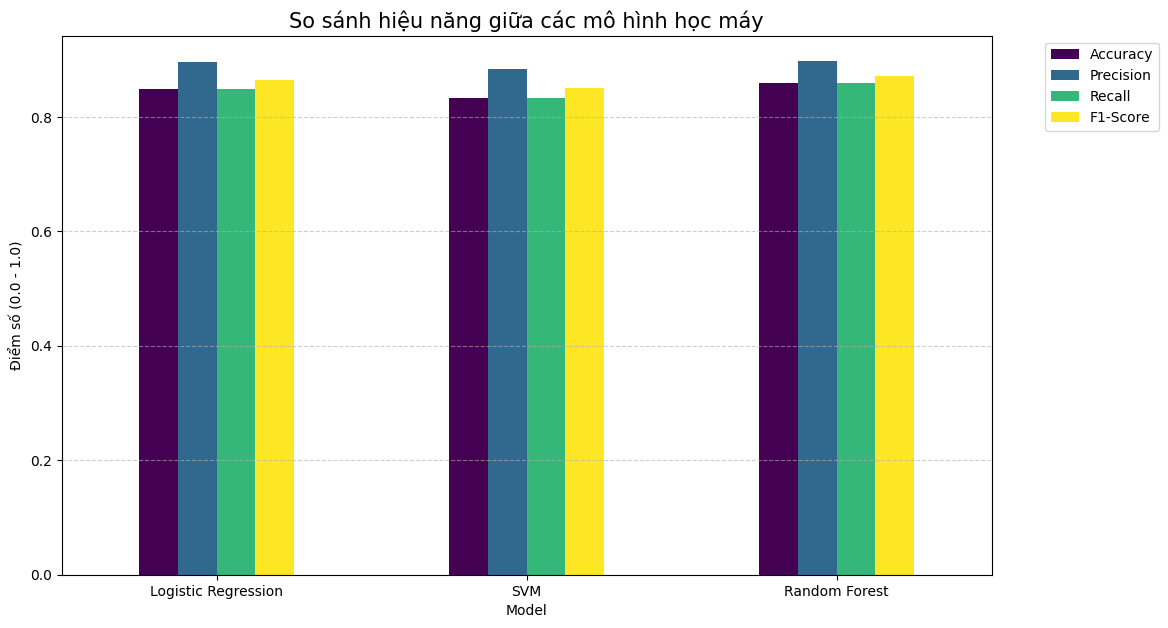

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def get_metrics(y_true, y_pred, model_name):
    # Tính toán các chỉ số weighted average
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return {
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3)
    }

# 1. Thu thập dữ liệu từ các mô hình đã huấn luyện
comparison_list = []
comparison_list.append(get_metrics(y_test_raw, y_pred, "Logistic Regression"))     # y_pred từ Mục 7
comparison_list.append(get_metrics(y_test_raw, y_pred_svm, "SVM"))               # y_pred_svm từ Mục 8
comparison_list.append(get_metrics(y_test_raw, y_pred_rf, "Random Forest"))      # y_pred_rf từ Mục 10

# 2. Tạo DataFrame so sánh
performance_df = pd.DataFrame(comparison_list).set_index("Model")

print("BẢNG SO SÁNH HIỆU NĂNG TỔNG THỂ:")
display(performance_df)

# 3. Trực quan hóa bằng biểu đồ cột
performance_df.plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title("So sánh hiệu năng giữa các mô hình học máy", fontsize=15)
plt.ylabel("Điểm số (0.0 - 1.0)")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV

# Từ điển để lưu trữ các mô hình tốt nhất sau khi tuning
tuned_models = {}

In [26]:
print("--- Đang Tuning Logistic Regression ---")
param_grid_lr = {
    'max_iter': [500, 1000, 1500],
}

# Sử dụng scoring='f1_weighted' vì tập dữ liệu có tính chất nhạy cảm
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_lr.fit(X_train_vec, balanced_train_df['labels'])

tuned_models['Logistic Regression'] = grid_lr.best_estimator_
print("Tham số tốt nhất cho LR:", grid_lr.best_params_)

--- Đang Tuning Logistic Regression ---
Tham số tốt nhất cho LR: {'max_iter': 500}


In [23]:
print("\n--- Đang Tuning SVM (LinearSVC) ---")
param_grid_svm = {
    'C': [0.1, 1.0, 10.0],
    'max_iter': [1000, 2000, 3000]
}

grid_svm = GridSearchCV(LinearSVC(random_state=42), param_grid_svm, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_svm.fit(X_train_vec, balanced_train_df['labels'])

tuned_models['SVM'] = grid_svm.best_estimator_
print("Tham số tốt nhất cho SVM:", grid_svm.best_params_)


--- Đang Tuning SVM (LinearSVC) ---
Tham số tốt nhất cho SVM: {'C': 1.0, 'max_iter': 1000}


In [24]:
print("\n--- Đang Tuning Random Forest ---")
param_grid_rf = {
    'n_estimators': [50, 100, 200], # Thử nghiệm các mức độ số lượng cây khác nhau
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train_vec, balanced_train_df['labels'])

tuned_models['Random Forest'] = grid_rf.best_estimator_
print("Tham số tốt nhất cho RF:", grid_rf.best_params_)


--- Đang Tuning Random Forest ---
Tham số tốt nhất cho RF: {'n_estimators': 100}



Báo cáo chi tiết cho Logistic Regression (Tuned):
              precision    recall  f1-score   support

        Hate       0.31      0.63      0.42       286
   Offensive       0.97      0.84      0.90      3838
     neither       0.76      0.94      0.84       833

    accuracy                           0.85      4957
   macro avg       0.68      0.80      0.72      4957
weighted avg       0.90      0.85      0.86      4957


Báo cáo chi tiết cho SVM (Tuned):
              precision    recall  f1-score   support

        Hate       0.28      0.58      0.38       286
   Offensive       0.96      0.84      0.89      3838
     neither       0.74      0.91      0.81       833

    accuracy                           0.83      4957
   macro avg       0.66      0.77      0.70      4957
weighted avg       0.88      0.83      0.85      4957


Báo cáo chi tiết cho Random Forest (Tuned):
              precision    recall  f1-score   support

        Hate       0.33      0.60      0.43       28

,Accuracy,F1-Score,Recall
Model,,,
Logistic Regression (Tuned),0.848,0.864,0.848
SVM (Tuned),0.833,0.850,0.833
Random Forest (Tuned),0.860,0.872,0.860


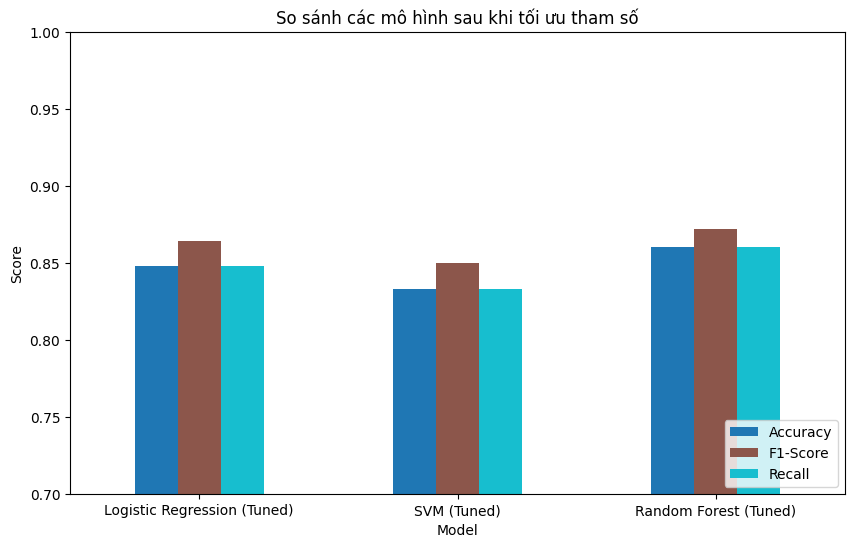

In [27]:
results_tuned = []

for name, model in tuned_models.items():
    # Dự đoán bằng mô hình đã được tối ưu
    y_pred_tuned = model.predict(X_test_vec)

    # Tính toán các chỉ số
    acc = accuracy_score(y_test_raw, y_pred_tuned)
    # Lấy thêm Precision, Recall, F1
    report = classification_report(y_test_raw, y_pred_tuned, output_dict=True)

    results_tuned.append({
        "Model": name + " (Tuned)",
        "Accuracy": round(acc, 3),
        "F1-Score": round(report["weighted avg"]["f1-score"], 3),
        "Recall": round(report["weighted avg"]["recall"], 3)
    })

    # In ma trận nhầm lẫn cho mô hình tốt nhất của mỗi loại
    print(f"\nBáo cáo chi tiết cho {name} (Tuned):")
    print(classification_report(y_test_raw, y_pred_tuned, target_names=["Hate", "Offensive", "neither"]))

# Hiển thị bảng so sánh
summary_tuned_df = pd.DataFrame(results_tuned).set_index("Model")
display(summary_tuned_df)

# Vẽ biểu đồ so sánh kết quả cuối cùng
summary_tuned_df.plot(kind='bar', figsize=(10, 6), colormap='tab10')
plt.title("So sánh các mô hình sau khi tối ưu tham số")
plt.ylabel("Score")
plt.ylim(0.7, 1.0) # Tập trung vào khoảng điểm cao để thấy rõ sự khác biệt
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

In [30]:
import joblib
import os

# 1. Xác định đường dẫn lưu trữ trên Google Drive
# Bạn có thể đổi tên thư mục 'HateSpeech_Project' tùy ý
save_directory = '/content/drive/MyDrive/HateSpeech_Project/'

# Tạo thư mục nếu chưa tồn tại
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print(f"Đã tạo thư mục mới tại: {save_directory}")

# 2. Lưu bộ vector hóa TF-IDF
# QUAN TRỌNG: Bạn bắt buộc phải lưu tfidf để xử lý các câu văn mới sau này
vectorizer_path = os.path.join(save_directory, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, vectorizer_path)
print(f"✅ Đã lưu TF-IDF Vectorizer tại: {vectorizer_path}")

# 3. Lưu các mô hình đã Tuning từ dictionary tuned_models của bạn
for model_name, model_obj in tuned_models.items():
    # Chuẩn hóa tên file (xóa khoảng trắng, viết thường)
    clean_name = model_name.lower().replace(" ", "_")
    model_file_path = os.path.join(save_directory, f'{clean_name}_tuned.pkl')

    # Thực hiện lưu mô hình
    joblib.dump(model_obj, model_file_path)
    print(f"✅ Đã lưu mô hình {model_name} tại: {model_file_path}")

print("\n--- HOÀN TẤT LƯU MÔ HÌNH ---")

Đã tạo thư mục mới tại: /content/drive/MyDrive/HateSpeech_Project/
✅ Đã lưu TF-IDF Vectorizer tại: /content/drive/MyDrive/HateSpeech_Project/tfidf_vectorizer.pkl
✅ Đã lưu mô hình Logistic Regression tại: /content/drive/MyDrive/HateSpeech_Project/logistic_regression_tuned.pkl
✅ Đã lưu mô hình SVM tại: /content/drive/MyDrive/HateSpeech_Project/svm_tuned.pkl
✅ Đã lưu mô hình Random Forest tại: /content/drive/MyDrive/HateSpeech_Project/random_forest_tuned.pkl

--- HOÀN TẤT LƯU MÔ HÌNH ---
